In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

Создам случайный датасет для анализа:

In [10]:
# Создаем синтетические данные для демонстрации
np.random.seed(42)
dates = pd.date_range('2024-01-01', '2024-03-31')
user_ids = range(10000, 15000)

data = []
for user_id in user_ids:
    date = np.random.choice(dates)
    # Преобразуем numpy datetime в pandas datetime для работы с strftime
    date_pd = pd.to_datetime(date)
    sessions = np.random.poisson(3) + 1
    
    # Генерируем события воронки
    events = []
    if np.random.random() < 0.95:  # 95% посетителей просматривают товары
        events.append(('view_product', date_pd))
        
        if np.random.random() < 0.6:  # 60% добавляют в корзину
            add_date = date_pd + timedelta(hours=np.random.exponential(2))
            events.append(('add_to_cart', add_date))
            
            if np.random.random() < 0.4:  # 40% оформляют заказ
                order_date = add_date + timedelta(hours=np.random.exponential(1))
                events.append(('purchase', order_date))
                
                if np.random.random() < 0.8:  # 80% оплачивают
                    payment_date = order_date + timedelta(hours=np.random.exponential(6))
                    events.append(('payment', payment_date))
    
    for event, event_date in events:
        data.append({
            'user_id': user_id,
            'event_type': event,
            'event_date': event_date,
            'session_id': f"{user_id}_{date_pd.strftime('%Y%m%d')}"  # Теперь работает
        })

df = pd.DataFrame(data)
print(f"Размер датасета: {df.shape}")
df.head()

Размер датасета: (9703, 4)


,user_id,event_type,event_date,session_id
0,10000,view_product,2024-02-21 00:00:00.000000,10000_20240221
1,10001,view_product,2024-01-24 00:00:00.000000,10001_20240124
2,10002,view_product,2024-01-02 00:00:00.000000,10002_20240102
3,10002,add_to_cart,2024-01-02 01:07:51.866881,10002_20240102
4,10002,purchase,2024-01-02 02:04:38.802027,10002_20240102


In [11]:
print(df.info())
event_counts = df['event_type'].value_counts()
print(event_counts)
print(f"\nПериод данных: с {df['event_date'].min()} по {df['event_date'].max()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9703 entries, 0 to 9702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     9703 non-null   int64         
 1   event_type  9703 non-null   object        
 2   event_date  9703 non-null   datetime64[ns]
 3   session_id  9703 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 303.3+ KB
None
event_type
view_product    4746
add_to_cart     2858
purchase        1162
payment          937
Name: count, dtype: int64

Период данных: с 2024-01-01 00:00:00 по 2024-03-31 16:21:49.169052


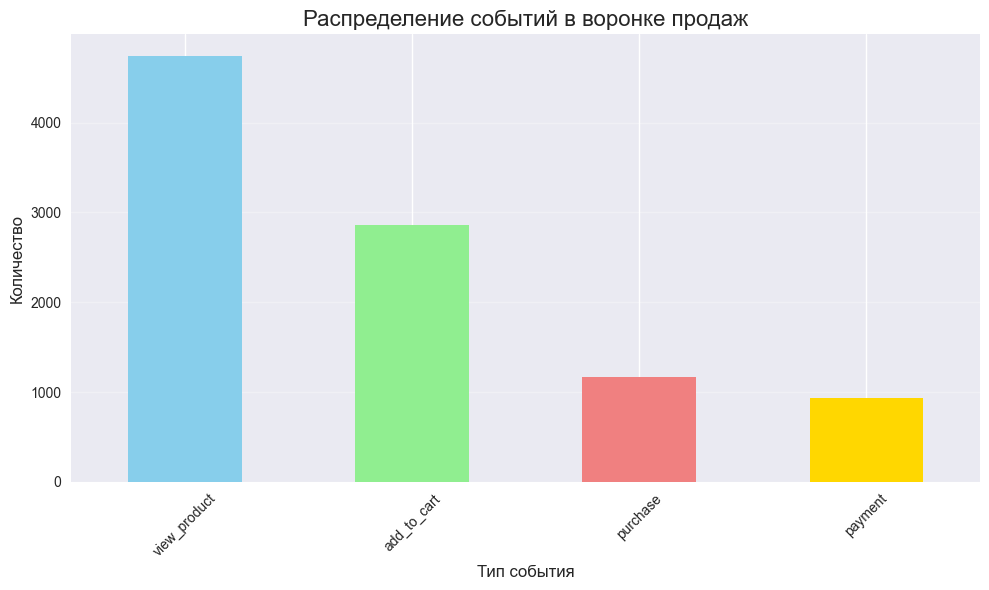

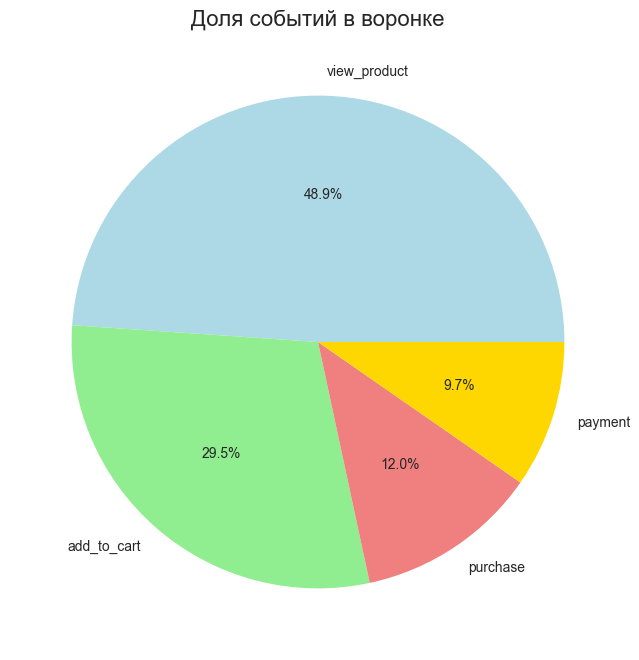

In [12]:
plt.figure(figsize=(10, 6))
event_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Распределение событий в воронке продаж', fontsize=16)
plt.xlabel('Тип события', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(event_counts.values, labels=event_counts.index, autopct='%1.1f%%', 
        colors=['lightblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Доля событий в воронке', fontsize=16)
plt.show()

In [13]:
# Расчет конверсии между этапами
def calculate_funnel(df):
    funnel_steps = ['view_product', 'add_to_cart', 'purchase', 'payment']
    funnel_data = {}
    
    for i, step in enumerate(funnel_steps):
        if i == 0:
            count = df[df['event_type'] == step]['user_id'].nunique()
        else:
            # Пользователи, которые дошли до текущего этапа
            prev_steps = funnel_steps[:i+1]
            users_with_all_prev = df[df['event_type'].isin(prev_steps)]\
                .groupby('user_id')['event_type'].nunique()
            count = (users_with_all_prev == (i+1)).sum()
        
        funnel_data[step] = count
    
    return pd.Series(funnel_data)

funnel_results = calculate_funnel(df)
print("Воронка продаж:")
print(funnel_results)

# Расчет конверсии
conversion_rates = []
for i in range(1, len(funnel_results)):
    rate = (funnel_results.iloc[i] / funnel_results.iloc[0]) * 100
    conversion_rates.append(rate)

print("\nКонверсия от первого этапа:")
for i, rate in enumerate(conversion_rates):
    print(f"{funnel_results.index[i+1]}: {rate:.2f}%")

Воронка продаж:
view_product    4746
add_to_cart     2858
purchase        1162
payment          937
dtype: int64

Конверсия от первого этапа:
add_to_cart: 60.22%
purchase: 24.48%
payment: 19.74%


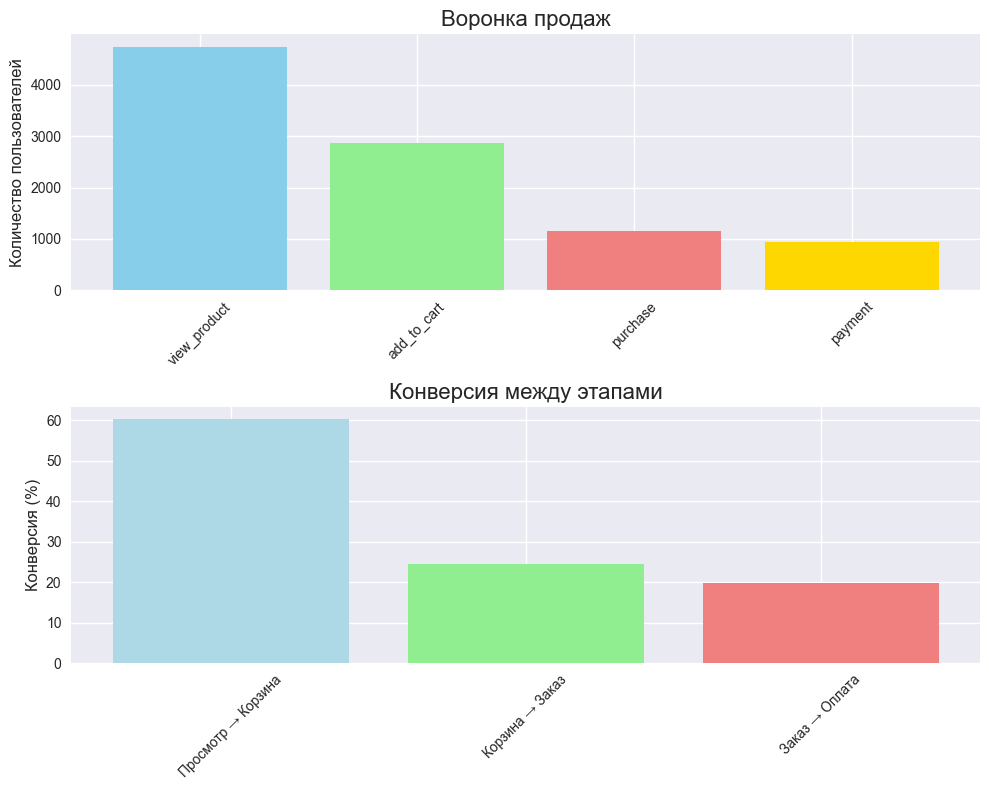

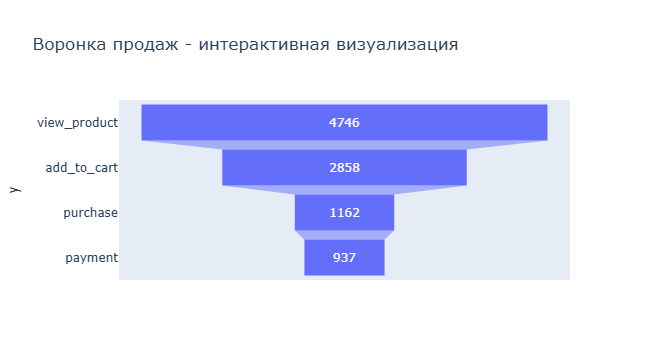

In [15]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.bar(funnel_results.index, funnel_results.values, 
        color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Воронка продаж', fontsize=16)
plt.ylabel('Количество пользователей', fontsize=12)
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
stages = ['Просмотр → Корзина', 'Корзина → Заказ', 'Заказ → Оплата']
plt.bar(stages, conversion_rates, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Конверсия между этапами', fontsize=16)
plt.ylabel('Конверсия (%)', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

fig = px.funnel(x=funnel_results.values, y=funnel_results.index,
               title='Воронка продаж - интерактивная визуализация')
fig.show()

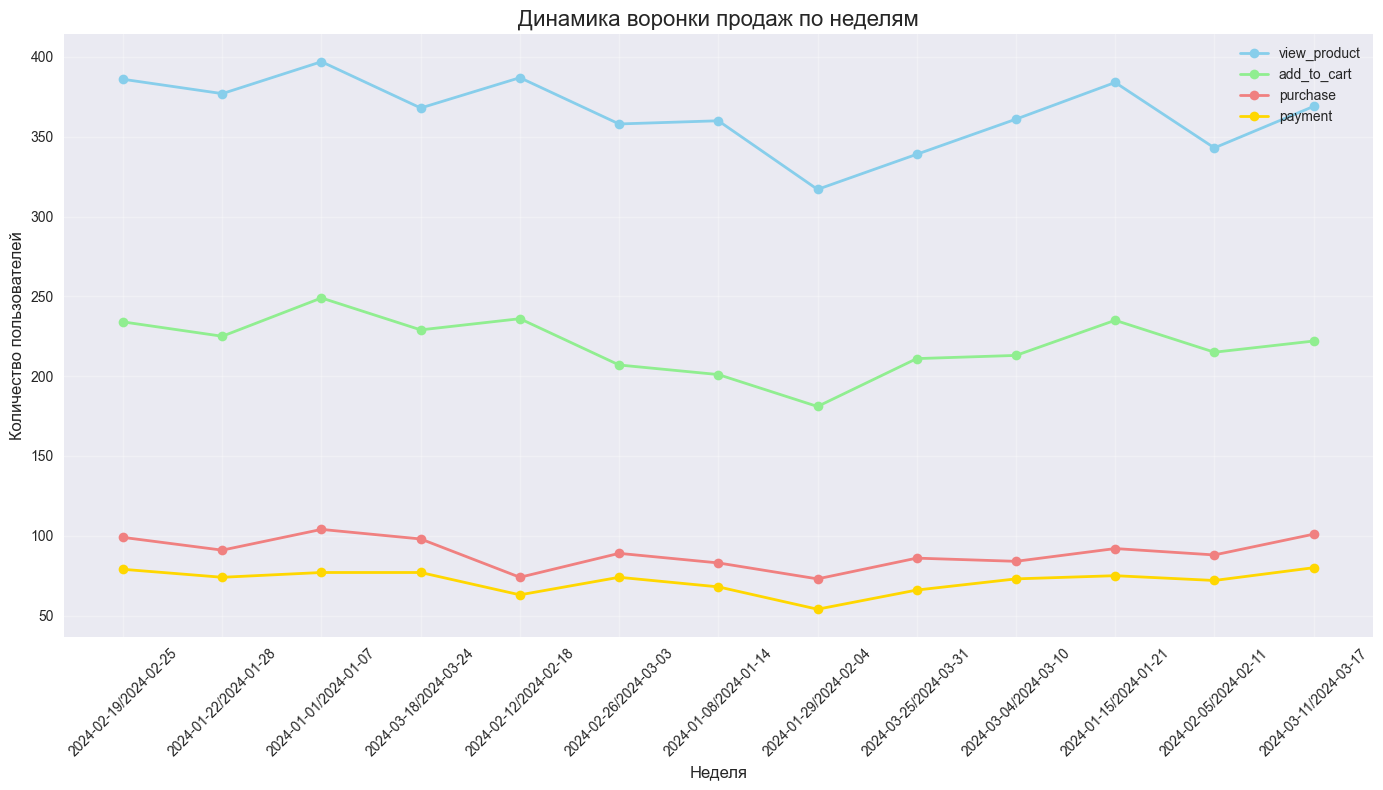

In [17]:
df['week'] = df['event_date'].dt.to_period('W')

weekly_data = []
for week in df['week'].unique():
    week_df = df[df['week'] == week]
    funnel_data = calculate_funnel(week_df)
    funnel_data['week'] = week
    weekly_data.append(funnel_data)

weekly_funnel = pd.DataFrame(weekly_data)
weekly_funnel['week_str'] = weekly_funnel['week'].astype(str)

plt.figure(figsize=(14, 8))
events = ['view_product', 'add_to_cart', 'purchase', 'payment']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

for i, event in enumerate(events):
    plt.plot(weekly_funnel['week_str'], weekly_funnel[event], 
             marker='o', label=event, linewidth=2, color=colors[i])

plt.title('Динамика воронки продаж по неделям', fontsize=16)
plt.xlabel('Неделя', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Распределение пользователей по глубине воронки:
funnel_depth
1    1888
2    1696
3     225
4     937
Name: count, dtype: int64


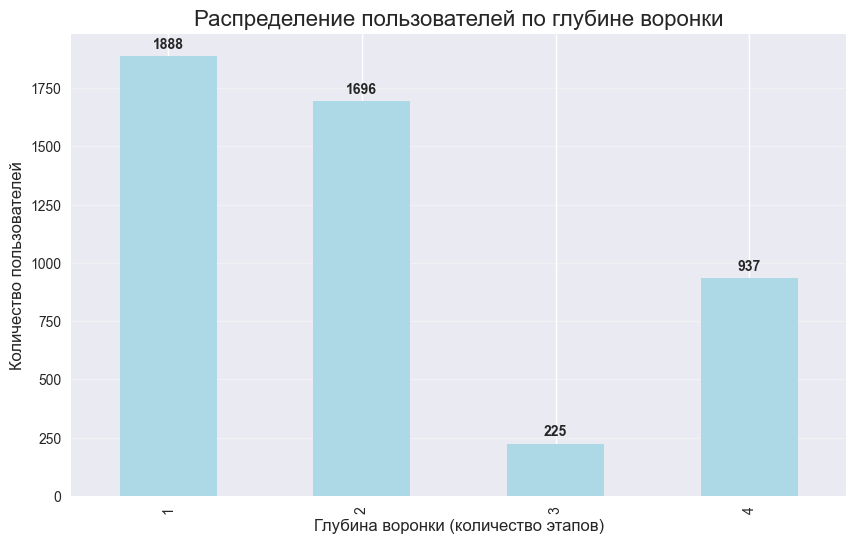


Анализ оттока:
                   Этап  Отток
0       Просмотр товара    192
1  Добавление в корзину   1471
2     Оформление заказа   -712
3                Этап 4    937


In [19]:

user_events = df.groupby('user_id')['event_type'].apply(list).reset_index()
user_events['funnel_depth'] = user_events['event_type'].apply(len)

print("Распределение пользователей по глубине воронки:")
depth_distribution = user_events['funnel_depth'].value_counts().sort_index()
print(depth_distribution)

plt.figure(figsize=(10, 6))
depth_distribution.plot(kind='bar', color='lightblue')
plt.title('Распределение пользователей по глубине воронки', fontsize=16)
plt.xlabel('Глубина воронки (количество этапов)', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(depth_distribution.values):
    plt.text(i, v + max(depth_distribution.values)*0.01, str(v), 
             ha='center', va='bottom', fontweight='bold')

plt.show()

dropoff_points = []
max_depth = depth_distribution.index.max()

for depth in range(1, max_depth + 1):
    if depth in depth_distribution.index:
        current = depth_distribution[depth]
        next_depth = depth_distribution[depth + 1] if (depth + 1) in depth_distribution.index else 0
        dropoff = current - next_depth
        if depth == 1:
            stage_name = 'Просмотр товара'
        elif depth == 2:
            stage_name = 'Добавление в корзину'
        elif depth == 3:
            stage_name = 'Оформление заказа'
        else:
            stage_name = f'Этап {depth}'
        dropoff_points.append((stage_name, dropoff))

dropoff_df = pd.DataFrame(dropoff_points, columns=['Этап', 'Отток'])
print("\nАнализ оттока:")
print(dropoff_df)

# АНАЛИЗ ВОРОНКИ ПРОДАЖ - ВЫВОДЫ И РЕКОМЕНДАЦИИ

In [25]:
funnel_data = calculate_funnel(df)

total_users = funnel_data.iloc[0] 
completed_funnel = funnel_data.iloc[-1] 
final_conversion = (completed_funnel / total_users) * 100

print(f"1. Общая конверсия: {final_conversion:.2f}%")
print(f"2. Наибольшие потери на этапе: {dropoff_df.loc[dropoff_df['Отток'].idxmax(), 'Этап']}")

print(f"\n4. КЛЮЧЕВЫЕ МЕТРИКИ:")
print(f"   - Всего пользователей: {total_users}")
print(f"   - Завершили всю воронку: {completed_funnel}")
print(f"   - Общая конверсия: {final_conversion:.2f}%")

1. Общая конверсия: 19.74%
2. Наибольшие потери на этапе: Добавление в корзину

4. КЛЮЧЕВЫЕ МЕТРИКИ:
   - Всего пользователей: 4746
   - Завершили всю воронку: 937
   - Общая конверсия: 19.74%


# Рекомендации

 'view_product → add_to_cart'
        "Оптимизировать UI/UX кнопки 'Добавить в корзину'",
        "Улучшить отображение цен и скидок",
        "Добавить отзывы и рейтинги товаров"
    
'add_to_cart → purchase': 
        "Упростить процесс оформления заказа",
        "Добавить возможность гостевого заказа",
        "Предложить бесплатную доставку"
    
'purchase → payment': 
        "Увеличить количество способов оплаты",
        "Упростить процесс оплаты",
        "Добавить сохранение платежных данных"
    